In [1]:
#loading dataset
import pandas as pd
import numpy as np
#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#EDA
from collections import Counter
import ydata_profiling as pp
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report, precision_score, f1_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#ensembling
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('heart.csv')
data.head()


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

In [3]:
y = data["target"]
X = data.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

x_Data= pd.DataFrame(X_train)
x_Datas= pd.DataFrame(X_test)

print(x_Datas)
# size_train = X_train.size()[0]
# size_test = X_test.size()[0]
# respond
# print(X_train)
# print(size_test)
# print(size_train)

          0         1         2         3         4         5         6   \
0   1.697165  0.696177 -0.922749  0.772516 -1.363541 -0.418040  0.901639   
1   1.024965  0.696177  1.940138  2.236257 -0.370312 -0.418040 -0.979367   
2   0.464799  0.696177  1.940138  2.236257  0.772838 -0.418040 -0.979367   
3   0.576832  0.696177 -0.922749 -0.398476  0.210633 -0.418040 -0.979367   
4   0.800899  0.696177  0.985842 -0.105728 -0.295351 -0.418040  0.901639   
..       ...       ...       ...       ...       ...       ...       ...   
56 -1.215700 -1.436416  0.985842 -0.808324 -0.089209 -0.418040  0.901639   
57  0.240733 -1.436416  0.031547 -0.105728 -0.201650 -0.418040 -0.979367   
58  0.464799  0.696177  0.985842  1.065265 -0.651414  2.392117  0.901639   
59 -0.543500 -1.436416  0.031547 -0.691224 -0.051729 -0.418040  0.901639   
60  0.352766 -1.436416 -0.922749 -1.862217  0.023232 -0.418040 -0.979367   

          7         8         9         10        11        12  
0  -1.073753  1.409842

In [4]:
svm_model = SVC(probability=True)
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

# Hyperparameter tuning for each base model
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}
knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=3)
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=3)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3)

svm_grid_search.fit(X_train, y_train)
knn_grid_search.fit(X_train, y_train)
rf_grid_search.fit(X_train, y_train)

best_svm_model = svm_grid_search.best_estimator_
best_knn_model = knn_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_

In [16]:
# Ensemble XGBoost model
xgb_model = XGBClassifier()

# Hyperparameter tuning for XGBoost
xgb_param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7], 'n_estimators': [10, 20, 40]}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3)
xgb_grid_search.fit(X_train, y_train)

best_xgb_model = xgb_grid_search.best_estimator_

# print(best_xgb_model)



In [12]:

# Create the ensemble using StackingCVClassifier
estimators = [('svm', best_svm_model), ('knn', best_knn_model), ('rf', best_rf_model)]
ensemble = StackingCVClassifier(classifiers=[est[1] for est in estimators], meta_classifier=best_xgb_model, cv=3)

# Train the ensemble on the validation set
ensemble.fit(X_train, y_train)

# Make predictions on the validation set
ensemble_predictions = ensemble.predict(X_test)

# Evaluate the accuracy of the ensemble on the validation set
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print(f"Ensemble Accuracy: {ensemble_accuracy}")

Ensemble Accuracy: 0.8524590163934426


## **FOR XGBOOST**

In [23]:
# Get predictions from base models
svm_predictions = best_svm_model.predict_proba(X_train)
knn_predictions = best_knn_model.predict_proba(X_train)
rf_predictions = best_rf_model.predict_proba(X_train)


In [24]:
# Concatenate predictions as new features
base_model_predictions = np.column_stack((svm_predictions[:, 1], knn_predictions[:, 1], rf_predictions[:, 1]))

# Train XGBoost model
xgb_model = XGBClassifier()

# Hyperparameter tuning for XGBoost
xgb_param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200]}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3)
xgb_grid_search.fit(base_model_predictions, y_train)

best_xgb_model = xgb_grid_search.best_estimator_

# Get predictions from base models on the validation set
svm_val_predictions = best_svm_model.predict_proba(X_test)
knn_val_predictions = best_knn_model.predict_proba(X_test)
rf_val_predictions = best_rf_model.predict_proba(X_test)

# prediect
svm_predictions = best_svm_model.predict(X_test)
knn_predictions = best_knn_model.predict(X_test)
rf_predictions = best_rf_model.predict(X_test)

# Evaluate the accuracy oknn_predictionsf the ensemble on the validation set
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions)

print(f"svm svn Accuracy: {svm_accuracy}")
print(f"svm svn Report: {svm_report}")

# Evaluate the accuracy of the ensemble on the validation set
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_report = classification_report(y_test, knn_predictions)


print(f"knn Accuracy: {knn_accuracy}")
print(f"knn svn Report: {knn_report}/n")


# Evaluate the accuracy of the ensemble on the validation set
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)


print(f"Ensemble rf Accuracy: {rf_accuracy}")
print(f"rf svn Report: {rf_report}")


svm svn Accuracy: 0.8688524590163934
svm svn Report:               precision    recall  f1-score   support

           0       0.91      0.78      0.84        27
           1       0.84      0.94      0.89        34

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.86        61
weighted avg       0.87      0.87      0.87        61

knn Accuracy: 0.8360655737704918
knn svn Report:               precision    recall  f1-score   support

           0       0.84      0.78      0.81        27
           1       0.83      0.88      0.86        34

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61
/n
Ensemble rf Accuracy: 0.8524590163934426
rf svn Report:               precision    recall  f1-score   support

           0       0.85      0.81      0.83        27
           1       0.86      0.88      0.87        34

    accuracy          

## **XGBoost**

In [79]:


# Concatenate predictions as new features for validation set
base_model_val_predictions = np.column_stack((svm_val_predictions[:, 1], knn_val_predictions[:, 1], rf_val_predictions[:, 1]))

# Make predictions using XGBoost on the validation set
xgb_val_predictions = best_xgb_model.predict(base_model_val_predictions)

# Evaluate the accuracy of the ensemble on the validation set
ensemble_accuracy = accuracy_score(y_test, xgb_val_predictions)
ensemble_f1_score = f1_score(y_test, xgb_val_predictions)
ensemble_pre_score = precision_score(y_test, xgb_val_predictions)
ensemble_recall_score = recall_score(y_test, xgb_val_predictions)
ensemble_report = classification_report(y_test, xgb_val_predictions)

print(f"Ensemble XGBoost Accuracy: {ensemble_accuracy}")
print(f"Ensemble XGBoost Report: {ensemble_report}")

Ensemble XGBoost Accuracy: 0.819672131147541
Ensemble XGBoost Report:               precision    recall  f1-score   support

           0       0.75      0.89      0.81        27
           1       0.90      0.76      0.83        34

    accuracy                           0.82        61
   macro avg       0.82      0.83      0.82        61
weighted avg       0.83      0.82      0.82        61



In [80]:
model_ev = pd.DataFrame({
    'Evaluation': ['Extreme Gradient Boost',], 
    'Accuracy': [ensemble_accuracy*100,],
    'F1_score': [ensemble_f1_score*100,], 
    'Precision': [ensemble_pre_score*100,],
    'recall': [ensemble_recall_score*100,],
    })
model_ev

Evaluation   Accuracy   F1_score  Precision     recall
0  Extreme Gradient Boost  81.967213  82.539683  89.655172  76.470588

**Random Forest**

In [70]:

model_ev = pd.DataFrame({
    'Evaluation': ['Random Forest',], 
    'Accuracy': [rf_accuracy*100,],
    'F1_score': [rf_f1_score*100,], 
    'Precision': [rf_pre_score*100,],
    'recall': [rf_recall_score*100,],
    })
model_ev

Evaluation   Accuracy   F1_score  Precision     recall
0  Random Forest  85.245902  86.956522  85.714286  88.235294

**Support vector Machine**


In [71]:
model_ev = pd.DataFrame({
    'Evaluation': ['Support Vector Machine',], 
    'Accuracy': [svm_accuracy*100,],
    'F1_score': [svm_f1_score*100,], 
    'Precision': [svm_pre_score*100,],
    'recall': [svm_recall_score*100,],
    })
model_ev

Evaluation   Accuracy   F1_score  Precision     recall
0  Support Vector Machine  86.885246  88.888889  84.210526  94.117647

**K_Nearest Neighbor**

In [72]:
model_ev = pd.DataFrame({
    'Evaluation': ['K_Nearest Neighbor',], 
    'Accuracy': [knn_accuracy*100,],
    'F1_score': [knn_f1_score*100,], 
    'Precision': [knn_pre_score*100,],
    'recall': [knn_recall_score*100,],
    })
model_ev

Evaluation   Accuracy   F1_score  Precision     recall
0  K_Nearest Neighbor  83.606557  85.714286  83.333333  88.235294

## **Important Features**

In [57]:
# random forest
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predictions) 
# knn                                                #  
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predictions)
# svm
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svm_predictions)
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_val_predictions)

[0]	eval-logloss:0.64597
[1]	eval-logloss:0.61320
[2]	eval-logloss:0.58429
[3]	eval-logloss:0.55935
[4]	eval-logloss:0.54285
[5]	eval-logloss:0.52218
[6]	eval-logloss:0.50852
[7]	eval-logloss:0.48977
[8]	eval-logloss:0.48041
[9]	eval-logloss:0.46592
[10]	eval-logloss:0.45529
[11]	eval-logloss:0.44719
[12]	eval-logloss:0.43577
[13]	eval-logloss:0.43175
[14]	eval-logloss:0.42313
[15]	eval-logloss:0.41526
[16]	eval-logloss:0.40602
[17]	eval-logloss:0.40502


[18]	eval-logloss:0.40096
[19]	eval-logloss:0.39730
[20]	eval-logloss:0.39788
[21]	eval-logloss:0.39603
[22]	eval-logloss:0.39222
[23]	eval-logloss:0.39071
[24]	eval-logloss:0.38743
[25]	eval-logloss:0.38432
[26]	eval-logloss:0.37863
[27]	eval-logloss:0.37466
[28]	eval-logloss:0.37514
[29]	eval-logloss:0.37186
[30]	eval-logloss:0.37220
[31]	eval-logloss:0.36956
[32]	eval-logloss:0.36613
[33]	eval-logloss:0.36152
[34]	eval-logloss:0.36091
[35]	eval-logloss:0.36026
[36]	eval-logloss:0.36120
[37]	eval-logloss:0.36068
[38]	eval-logloss:0.35833
[39]	eval-logloss:0.35892
[40]	eval-logloss:0.35524
[41]	eval-logloss:0.35198
[42]	eval-logloss:0.35069
[43]	eval-logloss:0.35037
[44]	eval-logloss:0.34924
[45]	eval-logloss:0.34875
[46]	eval-logloss:0.34775
[47]	eval-logloss:0.34812
[48]	eval-logloss:0.34769
[49]	eval-logloss:0.34922
[50]	eval-logloss:0.34797
[51]	eval-logloss:0.34604
[52]	eval-logloss:0.34415
[53]	eval-logloss:0.34420
[54]	eval-logloss:0.34047
[55]	eval-logloss:0.34152
[56]	eval-lo

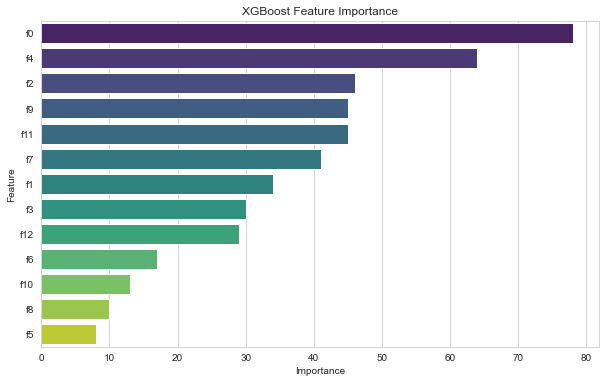

In [60]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)

# Create DMatrix for validation set
dval = xgb.DMatrix(X_test, label=y_test)

# Define hyperparameters
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'eta': 0.1, 'max_depth': 3}

# Train the XGBoost model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'eval')], early_stopping_rounds=10)

# Get feature importance values
feature_importance = bst.get_fscore()
# print(feature_importance.title)
# Convert to DataFrame
feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()


## **roc curve**

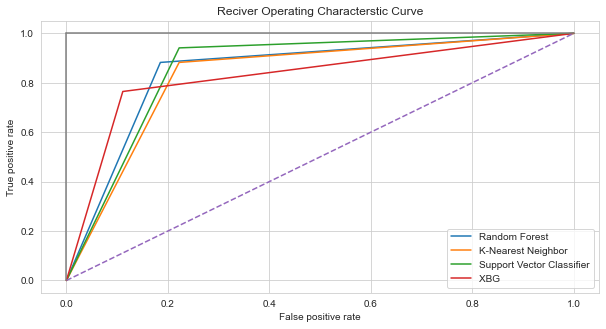

In [33]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='XBG ')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

**XGBOOST ENSEMBLE**

In [74]:
model_ev = pd.DataFrame({
    'Evaluation': ['Extreme Gradient Boost',], 
    'Accuracy': [xgb_accuracy*100,],
    'F1_score': [xgb_f1_score*100,], 
    'Precision': [xgb_pre_score*100,],
    'recall': [xgb_recall_score*100,],
    })
model_ev

NameError: name 'xgb_accuracy' is not defined

## **Model Evelaution**

In [63]:
model_ev = pd.DataFrame({
    'Model': ['Random Forest','K-Nearest Neighbour','Support Vector Machine', 'Ensemble Extreme Gradient'], 'Accuracy': [rf_accuracy*100, knn_accuracy*100,svm_accuracy*100, ensemble_accuracy*100]})
model_ev

Model   Accuracy
0              Random Forest  85.245902
1        K-Nearest Neighbour  83.606557
2     Support Vector Machine  86.885246
3  Ensemble Extreme Gradient  81.967213

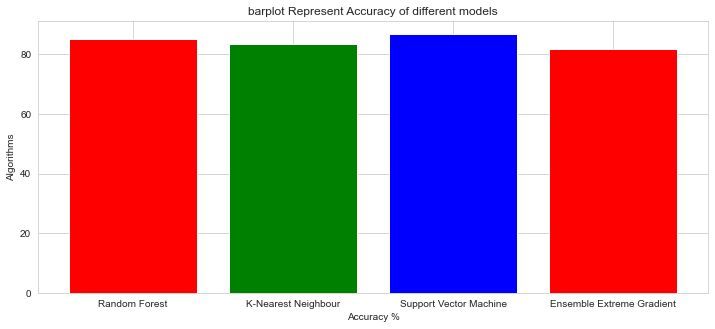

In [64]:
colors = ['red','green','blue']
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

In [69]:
svm_acc_score = accuracy_score(y_test, svm_predictions)
svm_f1_score= f1_score(y_test, svm_predictions)
svm_recall_score= recall_score(y_test, svm_predictions)
svm_pre_score = precision_score(y_test, svm_predictions)

# knn
knn_acc_score = accuracy_score(y_test, knn_predictions)
knn_f1_score= f1_score(y_test, knn_predictions)
knn_recall_score= recall_score(y_test, knn_predictions)
knn_pre_score = precision_score(y_test, knn_predictions)

# rf
rf_acc_score = accuracy_score(y_test, rf_predictions)
rf_f1_score= f1_score(y_test, rf_predictions)
rf_recall_score= recall_score(y_test, rf_predictions)
rf_pre_score = precision_score(y_test, rf_predictions)

# ensemble
xgb_acc_score = accuracy_score(y_test, ensemble_predictions)
xgb_f1_score= f1_score(y_test, ensemble_predictions)
xgb_recall_score= recall_score(y_test, ensemble_predictions)
xgb_pre_score = precision_score(y_test, ensemble_predictions)


model_ev = pd.DataFrame({
    'Model': ['Random Forest','K-Nearest Neighbour','Support Vector Machine', 'Ensemble Extreme Gradient'], 'Accuracy': [rf_accuracy*100, knn_accuracy*100,svm_accuracy*100, ensemble_accuracy*100],
    'F1_score': [rf_f1_score*100,knn_f1_score*100,svm_f1_score*100, xgb_f1_score*100], 
    'Precision': [rf_pre_score*100, knn_pre_score*100,svm_pre_score*100, xgb_pre_score*100],
    'recall': [rf_recall_score*100,knn_recall_score*100,svm_recall_score*100, xgb_recall_score*100],
    })
model_ev



Model   Accuracy   F1_score  Precision     recall
0              Random Forest  85.245902  86.956522  85.714286  88.235294
1        K-Nearest Neighbour  83.606557  85.714286  83.333333  88.235294
2     Support Vector Machine  86.885246  88.888889  84.210526  94.117647
3  Ensemble Extreme Gradient  81.967213  87.671233  82.051282  94.117647

In [ ]:
# random forest
# rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted) 
# knn                                                #  
# knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
# svm
# svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)
# scv
scv_false_positive_rate, scv_true_positive_rate, scv_threshold = roc_curve(y_test, scv_predicted)
# xgboost
xgb_false_positive_rate, xgb_true_positive_rate, xgb_threshold = roc_curve(y_test, xgb_predicted)
# plot
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
# plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
# plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
# plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot(scv_false_positive_rate,scv_true_positive_rate,label='Stack Vector classifier ')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='XGBoost',ls='--')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()